In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./graphs

%tensorflow_version 2.x

!apt-get update -y
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt install xvfb

!dpkg --configure -a
!pip install tqdm
!pip install box2d  
!pip install -q tf-agents

#http://fnl.es/a-quick-reference-for-working-with-tensorflow.html

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [1,341 kB]
Get:15 http://arc

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pyvirtualdisplay import Display

import tensorflow.compat.v1 as tf
from collections import deque
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input , BatchNormalization, Concatenate, LayerNormalization, LSTM,Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import random
import tqdm
import pandas as pd

tf.disable_eager_execution()
from google.colab import drive
drive.mount('/content/drive')
import math
import time
from tf_agents.utils import  value_ops

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tf.reset_default_graph()
epsilon = 1
#sess = tf.InteractiveSession()

#https://stackoverflow.com/questions/49432852/estimating-high-resolution-images-from-lower-ones-using-a-keras-model-based-on-c
#https://stackoverflow.com/questions/49603498/convolution2d-lstm-versus-convlstm2d
#https://stackoverflow.com/questions/49146881/passing-cnn-outputs-to-lstm-in-tensorflow


In [ ]:
class Agent:
  def __init__(self, name, state_shape, env, sess, reuse=False):
    """A simple actor-critic agent"""
    with tf.name_scope(name):
      self.name = name
      self.reuse = reuse
        
      # Prepare neural network architecture
      inputs = Input(shape=state_shape)
      x = Dense(64, activation='relu', name ="inp1")(inputs)
      rnn_in = Reshape((1 ,x.shape[1]), input_shape=x.shape)(x)
      x = LSTM(128, return_sequences=False, name ="lstm_enc_1")(rnn_in)

      """inputs = Input(shape=state_shape)
      x = Dense(32, activation='relu', name ="inp1")(inputs)
      #x = Dense(32, activation='relu', name ="inp2")(x)
      rnn_in = Reshape((1 ,x.shape[1]), input_shape=x.shape)(x)
      x = LSTM(64, return_sequences=False, name ="lstm_enc_1")(rnn_in)  GOOD RESULTS"""
      
      # two different output layers
      mu = Dense(units=env.action_space.shape[0], activation=tf.nn.tanh,name='actor_mu' )(x)
      sigma = Dense(units=env.action_space.shape[0], activation=tf.nn.softplus, name='actor_sigma' )(x)
      mu, sigma = tf.squeeze(mu*2), tf.squeeze(sigma +  1e-5)
      normal_dist = tfp.distributions.Normal(mu, sigma)
      action = tf.clip_by_value(normal_dist.sample(1), env.action_space.low[0], env.action_space.high[0])
      

      state_value = Dense(1, activation='linear', name ="v")(x)
      self.network = Model(inputs=inputs, outputs=[action, state_value,mu, sigma])

      # prepare a graph for agent step
      self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
      self.agent_outputs = self.symbolic_step(self.state_t)
      
  def symbolic_step(self, state_t):
    act,s,m, sig = self.network(state_t)
    state_values = s[:,0]
    return act, state_values, m, sig
  
  def sample_actions(self, state_t,epsilon):
      act,_,_,_= sess.run(self.agent_outputs, {self.state_t: state_t})
      return act


In [ ]:
class PendulumA3C:
  def __init__(self, sess,env, agent, lstm,gae):
    # These placeholders mean exactly the same as in "Let's try it out" section above
    self.sess =sess
    
    self.filepath = "/content/drive/My Drive/Colab Notebooks/RL/TF_pendulum/data.txt"
    self.batch_size =10
    self.memory = deque(maxlen= 500)
    self.gae_size = 20
    self.Training= 1000000#400000
    self.learning_rate= 0.0002#0.0004
    self.entropy_factor = 0.001

    self.rewards_history = []
    self.entropy_history = []
    self.actor_history =[]
    self.critic_history =[]
    self.advantage_history = []
    self.target_history =[]
    self.v_history =[]
    self.actionList =[]

    self.reward_step =0
    self.writer = tf.summary.FileWriter('./graphs', sess.graph)
    
    self.is_gae = gae
    self.isConvLSTM = lstm 
    self.env = env
    self.obs_shape = self.env.observation_space.shape
    self.n_actions = self.env.action_space.shape[0]

    print("Observation shape:", self.obs_shape)
    print("Num actions:", self.n_actions)

    self.agent = agent
    self.states_ph = tf.placeholder('float32', [None,] + list(self.obs_shape))    
    self.next_states_ph = tf.placeholder('float32', [None,] + list(self.obs_shape))
    self.actions_ph = tf.placeholder('float32', (None,))
    self.rewards_ph = tf.placeholder('float32', (None,))
    self.is_done_ph = tf.placeholder('float32', (None,))
    self.game_reward = tf.placeholder('float32', [None,])

    # logits[n_envs, n_actions] and state_values[n_envs, n_actions]
    self.act, self.state_values,self.mu, self.sigma = self.agent.symbolic_step(self.states_ph)
    self.next_act, self.next_state_values, self.next_mu, self.next_sigma = self.agent.symbolic_step(self.next_states_ph)

    # There is no next state if the episode is done!    
    self.gamma = 0.99

    if self.is_gae:
      self.final_value= self.next_state_values[-1]
      self.discounts = (1 - self.is_done_ph)*self.gamma
      
      self.advantage = value_ops.generalized_advantage_estimation( self.state_values, self.final_value, self.discounts, self.rewards_ph  , td_lambda=0.99, time_major=True)
      self.target_state_values = value_ops.discounted_return(self.rewards_ph, self.discounts, self.final_value)
      self.gae = self.advantage
      self.td_target = self.target_state_values 

    else:
      self.next_state_values = self.next_state_values * (1 - self.is_done_ph)
      self.advantage = self.rewards_ph + self.gamma*self.next_state_values - self.state_values
      self.target_state_values = self.rewards_ph+self.gamma*self.next_state_values

    self.normal_dist = tfp.distributions.Normal(self.mu, self.sigma)
    self.entropy = self.normal_dist.entropy() 

    self.actor_loss = -tf.reduce_mean((self.normal_dist.log_prob(self.actions_ph) * tf.stop_gradient(self.advantage)) + self.entropy_factor*self.entropy)
    self.critic_loss = tf.reduce_mean((self.state_values - tf.stop_gradient(self.target_state_values))**2, axis=0)
    self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.actor_loss + self.critic_loss)

    self.summary_adv = tf.summary.scalar('advantage_', tf.reduce_mean(self.advantage, axis=-1))
    self.summary_ent = tf.summary.scalar('entropy_',tf.reduce_mean(self.entropy, axis=-1))
    self.summary_target = tf.summary.scalar('target_state_values_',tf.reduce_mean(self.target_state_values, axis=-1))
    self.summary_act_loss = tf.summary.scalar('actor_loss_', self.actor_loss)
    self.summary_crit_loss = tf.summary.scalar('critic_loss_', self.critic_loss)
    self.summary_batchreward = tf.summary.scalar('batchreward', tf.reduce_mean(self.rewards_ph, axis=-1))
    self.summary_v = tf.summary.scalar('state_values', tf.reduce_mean(self.state_values, axis=-1))
    self.summary_r = tf.summary.scalar('mean_reward', tf.reduce_mean(self.game_reward, axis=-1))

  def evaluate(self, n_games=1):
      """Plays an a game from start till done, returns per-game rewards """
      game_rewards = []
      for _ in range(n_games):
          state = self.env.reset()

          total_reward = 0
          while True:
              action = self.agent.sample_actions([state],0)
              state, reward, done, info = self.env.step(action)
              total_reward += reward
              if done:
                  break

          game_rewards.append(total_reward)

      avr_reward =sess.run(self.summary_r, { self.game_reward: np.array(game_rewards).reshape(n_games,)})
                           
      self.writer.add_summary(avr_reward,self.reward_step)
      self.reward_step +=1

      return game_rewards

  def get_sample(self):
    #batch = random.sample(self.memory, self.gae_size)

    s = np.array([each[0] for each in self.memory])
    a = [each[1] for each in self.memory]
    s_ = np.array([each[2] for each in self.memory])
    r = [each[3] for each in self.memory]
    dones = [each[4] for each in self.memory]
    step = [each[5] for each in self.memory]
    return s,a,r,s_,dones,step
  #https://docs.google.com/spreadsheets/d/1DN7O7JZEmdUhmF0fmQT0JcNKe3eseuCKUnRwl27uveA/edit#gid=0
  #https://github.com/higgsfield/RL-Adventure-2/blob/master/2.gae.ipynb

  def train_gae(self):

    if len(self.memory) < self.gae_size:
      return

    s,a,r,s_,dones,steps = self.get_sample()
    
    ent = []
    actors =[]
    critics=[]
    targets_=[]
    states_v=[]
    gae_l=[]
    
    for j in range(self.batch_size):
      counter =0
      s__temp=[]
      s_temp=[]
      r_temp =[]
      dones_temp=[]
      a_temp=[]

      for x in range(len(r)):
        r_temp.append(r[x][j] )
        s_temp.append(s[x,j]) 
        dones_temp.append((dones[x][j]) )
        s__temp.append(s_[x,j])
        a_temp.append(a[x][j])
        counter +=1
        self.actionList.append(a[x][j])

        if dones[x][j] ==1:
          break

      s_temp_arr= (np.array(s_temp)).reshape((counter,self.env.observation_space.shape[0]))
      s__temp_arr= (np.array(s__temp)).reshape((counter,self.env.observation_space.shape[0]))

      feed_dict = {
              self.states_ph: s_temp_arr,
              self.actions_ph: a_temp,
              self.next_states_ph: s__temp_arr,
              self.rewards_ph: r_temp,
              self.is_done_ph: dones_temp,
          }
      _, ent_t,act,crit,target, gae, v,sum_ent,sum_act_loss,sum_crit_loss,sum_v,sum_gae = sess.run([self.train_step, self.entropy,self.actor_loss ,self.critic_loss,self.td_target,self.gae,#self.adv,self.final_value, self.discounts,    ,adv,final,disc
                                              self.state_values,self.summary_ent,self.summary_act_loss,self.summary_crit_loss,
                                              self.summary_v,self.summary_adv], feed_dict)


      self.writer.add_summary(sum_gae, self.gae_steps)
      self.writer.add_summary(sum_ent, self.gae_steps)
      self.writer.add_summary(sum_act_loss, self.gae_steps)
      self.writer.add_summary(sum_crit_loss, self.gae_steps)
      self.writer.add_summary(sum_v, self.gae_steps)
      self.gae_steps +=1


      ent.append(np.mean(ent_t))
      actors.append(np.mean(act))
      critics.append(np.mean(crit))
      targets_.append(np.mean(target))
      states_v.append(np.mean(v))
      gae_l.append(np.mean(gae))

    self.entropy_history.append(np.mean(ent))
    self.actor_history.append(np.mean(actors))
    self.critic_history.append(np.mean(critics))
    self.target_history.append(np.mean(targets_))
    self.v_history.append(np.mean(states_v))
    self.advantage_history.append(np.mean(gae_l))
    self.memory.clear()


  def train(self,batch_states,batch_actions,batch_next_states,batch_rewards,batch_done,step):
    batch_actions = batch_actions.reshape(self.batch_size,)
    
    feed_dict = {
            self.states_ph: batch_states,
            self.actions_ph: batch_actions,
            self.next_states_ph: batch_next_states,
            self.rewards_ph: batch_rewards,
            self.is_done_ph: batch_done,
        }

    _, ent_t,act,crit,adv,targ,v,sum_adv,sum_ent,sum_target,sum_act_loss,sum_crit_loss,sum_batchreward,sum_v = sess.run([self.train_step, self.entropy,self.actor_loss ,self.critic_loss,self.advantage,
                                             self.target_state_values,self.state_values,
                                             self.summary_adv,self.summary_ent,self.summary_target,self.summary_act_loss,self.summary_crit_loss,
                                             self.summary_batchreward,self.summary_v], feed_dict)

    self.writer.add_summary(sum_adv, step)
    self.writer.add_summary(sum_ent, step)
    self.writer.add_summary(sum_target, step)
    self.writer.add_summary(sum_act_loss, step)
    self.writer.add_summary(sum_crit_loss, step)
    self.writer.add_summary(sum_batchreward, step)
    self.writer.add_summary(sum_v, step)

    self.entropy_history.append(np.mean(ent_t))
    self.actor_history.append(np.mean(act))
    self.critic_history.append(np.mean(crit))
    self.advantage_history.append(np.mean(adv))
    self.target_history.append(np.mean(targ))
    self.v_history.append(np.mean(v))
    for a in batch_actions:
      self.actionList.append(a)


  def ewma(self,x, span=100):
    return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

  def plots(self):
    ipythondisplay.clear_output(wait=True)
    plt.figure(figsize=[35,13])
    plt.subplot(2,4,1)
    plt.plot(self.rewards_history, label='reward')
    plt.plot(self.ewma(np.array(self.rewards_history), span=10), marker='.', label='rewards ewma@10')
    plt.title("Session rewards"); plt.grid(); plt.legend()

    plt.subplot(2,4,2)
    plt.plot(self.actor_history, label='Actor Loss')
    plt.plot(self.ewma(np.array(self.actor_history), span=10), marker='.', label='Actor Loss ewma@10')
    plt.title("Policy Function"); plt.grid(); plt.legend()  

    plt.subplot(2,4,3)
    plt.plot(self.entropy_history, label='Entropy')
    plt.plot(self.ewma(np.array(self.entropy_history), span=10), marker='.', label='Entropy ewma@10')
    plt.title("Policy Function"); plt.grid(); plt.legend()      
    
    plt.subplot(2,4,4)
    plt.plot(self.target_history, label='Target ')
    plt.plot(self.v_history, label='V')
    plt.title("Target/V"); plt.grid(); plt.legend()

    plt.subplot(2,4,5)
    plt.plot(self.advantage_history, label='Advantage')
    plt.title("Advantage"); plt.grid(); plt.legend()  

    plt.subplot(2,4,6)
    plt.plot(self.critic_history, label='Critic Loss')
    plt.plot(self.ewma(np.array(self.critic_history), span=10), marker='.', label='Critic Loss ewma@10')
    plt.title("Value function"); plt.grid(); plt.legend()   

    plt.subplot(2,4,7)
    plt.plot(self.actionList, label='Actions')
    plt.title("Actions"); plt.grid(); plt.legend()  

    plt.show()
    


In [ ]:
class EnvBatch:
  def __init__(self, n_envs = 10):
    """ Creates n_envs environments and babysits them for ya' """
    self.envs = [gym.make("Pendulum-v0") for _ in range(n_envs)]
    
  def reset(self):
    """ Reset all games and return [n_envs, *obs_shape] observations """
    return np.array([env.reset() for env in self.envs])
  
  def step(self, actions):
    """
    Send a vector[batch_size] of actions into respective environments
    :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
    """
    results = [env.step([a]) for env, a in zip(self.envs, actions)]
    new_obs, rewards, done, infos = map(np.array, zip(*results))

    # reset environments automatically
    for i in range(len(self.envs)):
      if done[i]:
        new_obs[i] = self.envs[i].reset()
    
    return new_obs, rewards, done, infos


In [ ]:
sess = tf.Session(graph= tf.get_default_graph())
RESET = 1
is_gae = False
isConvLSTM = True 


In [ ]:
display = Display(visible=0, size=(400, 300))
display.start()
env = gym.make("Pendulum-v0")
agent = Agent("agent", env.observation_space.shape, env, sess,isConvLSTM)
pendulumA3C = PendulumA3C(sess,env,agent, isConvLSTM,is_gae)



Observation shape: (3,)
Num actions: 1


In [ ]:

if (RESET == 1):
  # ************ RESET everything **************************
  sess.run(tf.global_variables_initializer())
  saver = tf.train.Saver()
  f=open(pendulumA3C.filepath, "w")
  f.write("")
  f.close()
else:
  # ************ LOAD everything **************************
  epsilon = 0.0001
  saver = tf.train.Saver()
  saver.restore(sess, tf.train.latest_checkpoint('/content/drive/My Drive/Colab Notebooks/RL/TF_pendulum/'))
  !cp -r  /content/drive/My\ Drive/Colab\ Notebooks/RL/TF_pendulum/graphs/ /content/ 
  pendulumA3C.plots()

# Validate
rewards = pendulumA3C.evaluate(n_games=3)
print(rewards)

env_batch = EnvBatch(10)
batch_states = env_batch.reset()
batch_actions = pendulumA3C.agent.sample_actions(batch_states,0)
batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions[0])

print("State shape:", batch_states.shape)
print("Actions:", batch_actions)
print("Rewards:", batch_rewards)
print("Done:", batch_done)

#Initialize
env_batch = EnvBatch(10)
batch_states = env_batch.reset()

[-1671.9712799671845, -1165.6256842728803, -1517.7263214784261]
State shape: (10, 3)
Actions: [[-0.2554308   0.33019868  0.610302    0.09505045 -1.0438497   0.7755739
  -0.6436357   0.4285897  -0.7246752   0.1812132 ]]
Rewards: [-1.367241   -0.04494498 -0.11162447 -0.7810073  -1.85007902 -2.84844868
 -2.10141511 -2.32175595 -5.07477305 -0.05626601]
Done: [False False False False False False False False False False]


In [ ]:
%tensorboard --logdir graphs
time.sleep(15)

Reusing TensorBoard on port 6006 (pid 1586), started 1:18:53 ago. (Use '!kill 1586' to kill it.)

<IPython.core.display.Javascript object>

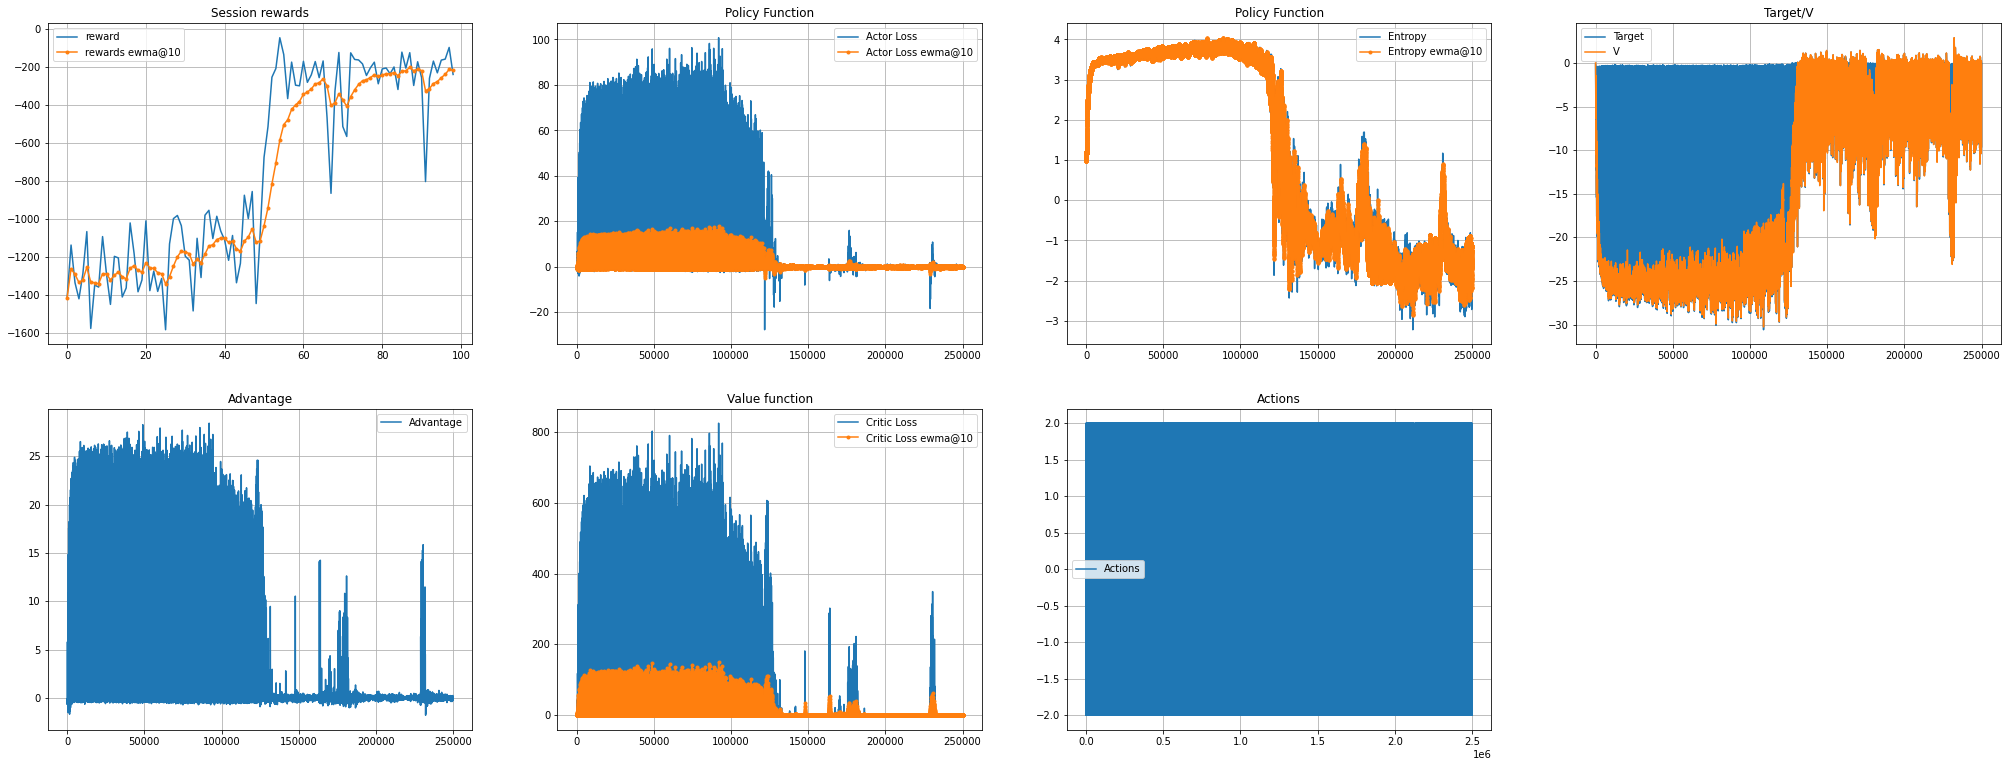

 25%|██▌       | 252498/1000000 [39:29<1:56:53, 106.57it/s]

Your agent reached the objetive


In [11]:
#f=open(pendulumA3C.filepath, "w")
epsilon = 0
with tqdm.trange(len(pendulumA3C.entropy_history), pendulumA3C.Training) as t:
  for i in t:
    batch_actions = pendulumA3C.agent.sample_actions(batch_states,epsilon)
    batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions[0])

    # Reward scaling
    batch_rewards = batch_rewards /16.2736044

    if is_gae :
      pendulumA3C.memory.append([batch_states,batch_actions,batch_next_states,batch_rewards,batch_done,i])
      pendulumA3C.train_gae()
    else:
      pendulumA3C.train(batch_states,batch_actions,batch_next_states,batch_rewards,batch_done,i)

    batch_states = batch_next_states

    if len(pendulumA3C.rewards_history)> 100 :
      if np.mean(pendulumA3C.rewards_history[-50:]) >= -400:
        print("Your agent reached the objetive")
        break

    if i % 500 == 0 and i >0:
      
      if i % 50000 == 0:
        saver.save(sess, "/content/drive/My Drive/Colab Notebooks/RL/TF_pendulum/model.h5")
        !cp -r  /content/graphs/ /content/drive/My\ Drive/Colab\ Notebooks/RL/TF_pendulum/
        pendulumA3C.plots()

      if i % 2500 == 0:
        pendulumA3C.rewards_history.append(np.mean(pendulumA3C.evaluate(n_games=3)))

      """if epsilon > 0.001 :
        epsilon = epsilon*0.99"""

      
      """if i %10000 ==0:
        pendulumA3C.plots()
        f.close()
        f=open(pendulumA3C.filepath, "a+")
          

        f.write("%f %f %f %f %f %f %f\n" % (pendulumA3C.rewards_history[-1],pendulumA3C.actor_history[-1], pendulumA3C.entropy_history[-1], pendulumA3C.target_history[-1], pendulumA3C.v_history[-1], pendulumA3C.advantage_history[-1], pendulumA3C.critic_history[-1]))"""

#f.close()

In [12]:
def evaluate2(agent, env, n_games=1):
  """Plays an a game from start till done, returns per-game rewards """
  game_rewards = []
  for _ in range(n_games):
      state = env.reset()

      total_reward = 0
      while True:
          action = agent.sample_actions([state],0)
          state, reward, done, info = env.step(action)
          total_reward += reward
          if done:
              break

      game_rewards.append(total_reward)
  return game_rewards

env_monitor = gym.wrappers.Monitor(env, directory="/content/drive/My Drive/Colab Notebooks/RL/TF_pendulum/videos", force=True)
final_rewards = evaluate2(pendulumA3C.agent, env_monitor, n_games=100)
env_monitor.close()

print("Final mean reward:", np.mean(final_rewards))

Final mean reward: -163.5497061677061
